# Data Loader

In [6]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader


class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


features_concatenate_train = np.load('Features/concatenate/waveform_without_emotion_av_train.npy', allow_pickle=True)
features_concatenate_val   = np.load('Features/concatenate/waveform_without_emotion_av_val.npy', allow_pickle=True)
features_concatenate_test  = np.load('Features/concatenate/waveform_without_emotion_mul_test.npy', allow_pickle=True)

labels_train = np.load('Features/labels_av_train.npy', allow_pickle=True)
labels_val   = np.load('Features/labels_av_val.npy', allow_pickle=True)
labels_test  = np.load('Features/labels_mul_test.npy', allow_pickle=True)

labels_train_tensor = [torch.tensor(arr, dtype=torch.float32) for arr in labels_train]
labels_val_tensor   = [torch.tensor(arr, dtype=torch.float32) for arr in labels_val]
labels_test_tensor  = [torch.tensor(arr, dtype=torch.float32) for arr in labels_test]

md_train = MyDataset(features_concatenate_train, labels_train_tensor)
md_val   = MyDataset(features_concatenate_val, labels_val_tensor)
md_test  = MyDataset(features_concatenate_test, labels_test_tensor)

train_dataloader = DataLoader(md_train, batch_size=1, shuffle=True)
val_dataloader   = DataLoader(md_val, batch_size=1)
test_dataloader  = DataLoader(md_test, batch_size=1)


In [7]:
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(401, 140, 163)

# LSTM Highlight Detection Model

In [4]:
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score

# === Define LSTMClassifier ===
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        output = self.fc(out[:, -1, :])  # [batch, 1]
        return output, out[:, -1, :]

# === Compute pos_weight automatically from train dataloader ===
def compute_pos_weight(dataloader):
    total_pos = 0
    total_count = 0
    for inputs, labels in dataloader:
        total_pos += labels.sum().item()
        total_count += labels.numel()
    pos_ratio = total_pos / total_count
    pos_weight_value = (1 - pos_ratio) / pos_ratio
    print(f"📊 Positive ratio: {pos_ratio:.4f} → pos_weight: {pos_weight_value:.4f}")
    return torch.tensor([pos_weight_value], dtype=torch.float32)

# === Training Configuration ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 2000
hidden_size = 256
num_layers = 3
output_size = 1
num_epochs = 100
learning_rate = 5e-4 
threshold = 0.3

# === Initialize model, optimizer, loss ===
model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)
pos_weight = compute_pos_weight(train_dataloader).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


📊 Positive ratio: 0.3684 → pos_weight: 1.7142


In [5]:

# === Training Loop ===
best_f1 = 0.0
train_loss_history, val_loss_history = [], []

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    total_loss = 0.0

    for inputs, labels in train_dataloader:
        if inputs.shape[1] != labels.shape[1]:
            continue
        inputs = inputs.transpose(0, 1).to(device)      # [seq, batch, feature]
        labels = labels.squeeze(0).to(device)

        optimizer.zero_grad()
        outputs, _ = model(inputs)
        outputs = outputs.squeeze(1)                    # [seq]
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    train_loss_history.append(avg_train_loss)

     # === Validation ===
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            if inputs.shape[1] != labels.shape[1]:
                continue
            inputs = inputs.transpose(0, 1).to(device)
            labels = labels.squeeze(0).to(device)
            outputs, _ = model(inputs)
            outputs = outputs.squeeze(1)
            probs = torch.sigmoid(outputs)  # ✅ apply sigmoid
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    bin_preds = (all_preds > threshold).astype(int)
    
    f1 = f1_score(all_labels, bin_preds, zero_division=0)
    precision = precision_score(all_labels, bin_preds, zero_division=0)
    recall = recall_score(all_labels, bin_preds, zero_division=0)
    acc = (bin_preds == all_labels).mean()
    
    # loss 계산 시 logits가 아닌 probs를 넣지 않도록 주의해야 함!
    logits_tensor = torch.tensor(all_preds, dtype=torch.float32).to(device)
    labels_tensor = torch.tensor(all_labels, dtype=torch.float32).to(device)
    val_loss = criterion(logits_tensor.logit(), labels_tensor).item()  # 또는 원래 logits 저장해두고 사용
    
    val_loss_history.append(val_loss)
    

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | "
          f"F1: {f1:.4f} | P: {precision:.4f} | R: {recall:.4f} | Acc: {acc:.4f}")

    # Save best model
    if f1 > best_f1:
        best_f1 = f1
        print(f"Best F1: {f1:.4f} | P: {precision:.4f} | R: {recall:.4f} | Acc: {acc:.4f}")
        #torch.save(model.state_dict(), f"best_lstm_audio_model_epoch{epoch+1}.pt")


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100 | Train Loss: 0.5297 | F1: 0.5163 | P: 0.3479 | R: 1.0000 | Acc: 0.3479
Best F1: 0.5163 | P: 0.3479 | R: 1.0000 | Acc: 0.3479
Epoch 2/100 | Train Loss: 0.5257 | F1: 0.5163 | P: 0.3479 | R: 1.0000 | Acc: 0.3479
Epoch 3/100 | Train Loss: 0.5176 | F1: 0.5158 | P: 0.3487 | R: 0.9905 | Acc: 0.3530
Epoch 4/100 | Train Loss: 0.5050 | F1: 0.5112 | P: 0.3501 | R: 0.9466 | Acc: 0.3701
Epoch 5/100 | Train Loss: 0.4839 | F1: 0.5103 | P: 0.3533 | R: 0.9180 | Acc: 0.3869
Epoch 6/100 | Train Loss: 0.4538 | F1: 0.5048 | P: 0.3556 | R: 0.8698 | Acc: 0.4062
Epoch 7/100 | Train Loss: 0.4227 | F1: 0.4998 | P: 0.3593 | R: 0.8211 | Acc: 0.4283
Epoch 8/100 | Train Loss: 0.3928 | F1: 0.4919 | P: 0.3620 | R: 0.7671 | Acc: 0.4486
Epoch 9/100 | Train Loss: 0.3713 | F1: 0.4934 | P: 0.3637 | R: 0.7671 | Acc: 0.4519
Epoch 10/100 | Train Loss: 0.3476 | F1: 0.4934 | P: 0.3643 | R: 0.7640 | Acc: 0.4540
Epoch 11/100 | Train Loss: 0.3357 | F1: 0.4823 | P: 0.3666 | R: 0.7049 | Acc: 0.4735
Epoch 12/100 | Train

# Evaluation

In [9]:
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score

# === Define LSTMClassifier ===
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        output = self.fc(out[:, -1, :])  # [batch, 1]
        return output, out[:, -1, :]

# === Compute pos_weight automatically from train dataloader ===
def compute_pos_weight(dataloader):
    total_pos = 0
    total_count = 0
    for inputs, labels in dataloader:
        total_pos += labels.sum().item()
        total_count += labels.numel()
    pos_ratio = total_pos / total_count
    pos_weight_value = (1 - pos_ratio) / pos_ratio
    print(f"📊 Positive ratio: {pos_ratio:.4f} → pos_weight: {pos_weight_value:.4f}")
    return torch.tensor([pos_weight_value], dtype=torch.float32)

# === Training Configuration ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 2000
hidden_size = 256
num_layers = 3
output_size = 1
num_epochs = 100
learning_rate = 5e-4 
threshold = 0.3

# === Initialize model, optimizer, loss ===
model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)
pos_weight = compute_pos_weight(train_dataloader).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# === Load pretrained model weights ===
model_path = "Model/Audio/audio_highlight_detection_wo_emotion_20250419_2150.pt"
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)
print(f"✅ Loaded model from: {model_path}")


📊 Positive ratio: 0.3684 → pos_weight: 1.7142
✅ Loaded model from: Model/Audio/audio_highlight_detection_wo_emotion_20250419_2150.pt


Evaluating on Test Set:   0%|          | 0/163 [00:00<?, ?it/s]

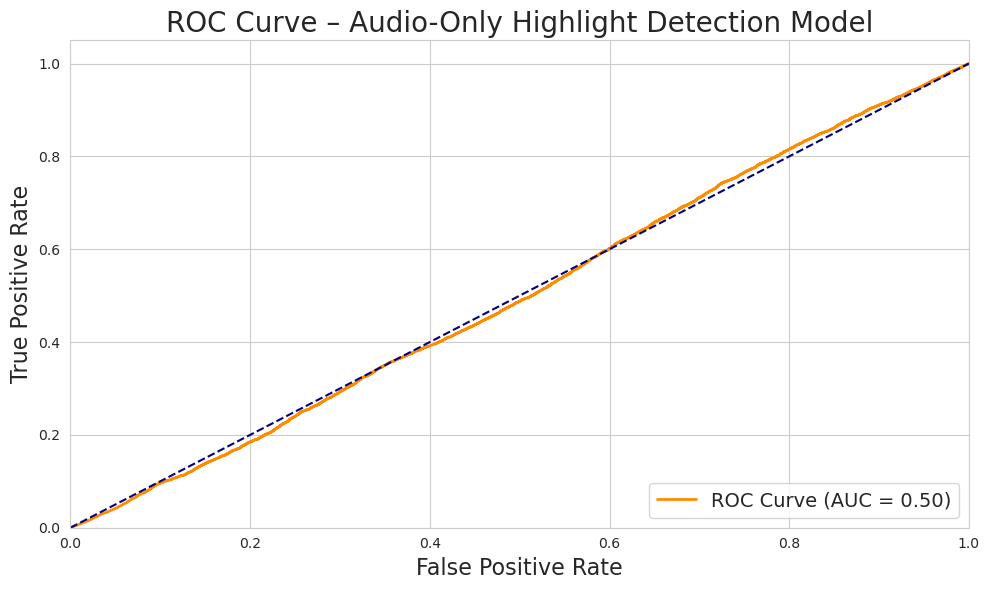

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

# === Evaluation on Test Set ===
model.eval()
y_true = []
y_score = []

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader, desc="Evaluating on Test Set"):
        if inputs.shape[1] != labels.shape[1]:
            continue
        inputs = inputs.transpose(0, 1).to(device)
        labels = labels.squeeze(0).to(device)

        logits, _ = model(inputs)                    # raw logits
        logits = logits.squeeze(1)

        probs = torch.sigmoid(logits)                # convert to probabilities
        y_score.extend(probs.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# === Convert to NumPy arrays ===
y_true = np.array(y_true)
y_score = np.array(y_score)

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curve – Audio-Only Highlight Detection Model', fontsize=20)
plt.legend(loc="lower right", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score
)
import pandas as pd
import seaborn as sns

# === Threshold-based Metric Calculation ===
thresholds = np.arange(0.0, 1.05, 0.05)
results = {
    'Threshold': [],
    'F1 Score': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': []
}

for t in thresholds:
    y_pred = (y_score > t).astype(int)
    results['Threshold'].append(t)
    results['F1 Score'].append(f1_score(y_true, y_pred, zero_division=0))
    results['Accuracy'].append(accuracy_score(y_true, y_pred))
    results['Precision'].append(precision_score(y_true, y_pred, zero_division=0))
    results['Recall'].append(recall_score(y_true, y_pred, zero_division=0))

df_metrics = pd.DataFrame(results)

# === Plot Threshold-based Metrics ===
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(df_metrics['Threshold'], df_metrics['F1 Score'], label='F1 Score', color='royalblue', linestyle='-')
plt.plot(df_metrics['Threshold'], df_metrics['Accuracy'], label='Accuracy', color='darkorange', linestyle='-')
plt.plot(df_metrics['Threshold'], df_metrics['Precision'], label='Precision', color='seagreen', linestyle='-')
plt.plot(df_metrics['Threshold'], df_metrics['Recall'], label='Recall', color='firebrick', linestyle='-')

plt.title("Performance Metrics - Audio-Only Highlight Detection Model", fontsize=20)
plt.xlabel("Threshold", fontsize=16)
plt.ylabel("Score", fontsize=16)
plt.legend(loc="upper left", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'np' is not defined

In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# 1. numpy 배열로 변환
y_true = np.array(y_true)
y_score = np.array(y_score)

# 2. 결과 저장용 리스트
thresholds = np.arange(0, 1.05, 0.05)
results = {
    "Threshold": [],
    "F1 Score": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": []
}

# 3. Threshold 별로 성능 계산
for th in thresholds:
    preds = (y_score > th).astype(int)

    f1 = f1_score(y_true, preds, zero_division=0)
    acc = accuracy_score(y_true, preds)
    prec = precision_score(y_true, preds, zero_division=0)
    rec = recall_score(y_true, preds, zero_division=0)

    results["Threshold"].append(th)
    results["F1 Score"].append(f1)
    results["Accuracy"].append(acc)
    results["Precision"].append(prec)
    results["Recall"].append(rec)

# 4. DataFrame 으로 출력
df_metrics = pd.DataFrame(results)
print(df_metrics)


    Threshold  F1 Score  Accuracy  Precision    Recall
0        0.00  0.540124  0.369980   0.369980  1.000000
1        0.05  0.433186  0.486020   0.365874  0.530851
2        0.10  0.420640  0.491919   0.363803  0.498526
3        0.15  0.413614  0.497414   0.363885  0.479087
4        0.20  0.407766  0.500848   0.363411  0.464453
5        0.25  0.402379  0.504687   0.363420  0.450693
6        0.30  0.396030  0.508283   0.362958  0.435732
7        0.35  0.390054  0.513374   0.363679  0.420553
8        0.40  0.380739  0.519879   0.364135  0.398930
9        0.45  0.371666  0.529778   0.367539  0.375887
10       0.50  0.365381  0.535152   0.369148  0.361691
11       0.55  0.359908  0.538384   0.369535  0.350770
12       0.60  0.355018  0.540929   0.369665  0.341487
13       0.65  0.349219  0.542061   0.368204  0.332096
14       0.70  0.345080  0.544970   0.369076  0.324014
15       0.75  0.336770  0.545172   0.365660  0.312111
16       0.80  0.330504  0.547394   0.365017  0.301955
17       0

In [12]:
print("Logits std:", outputs.std().item())

Logits std: 10.657712936401367


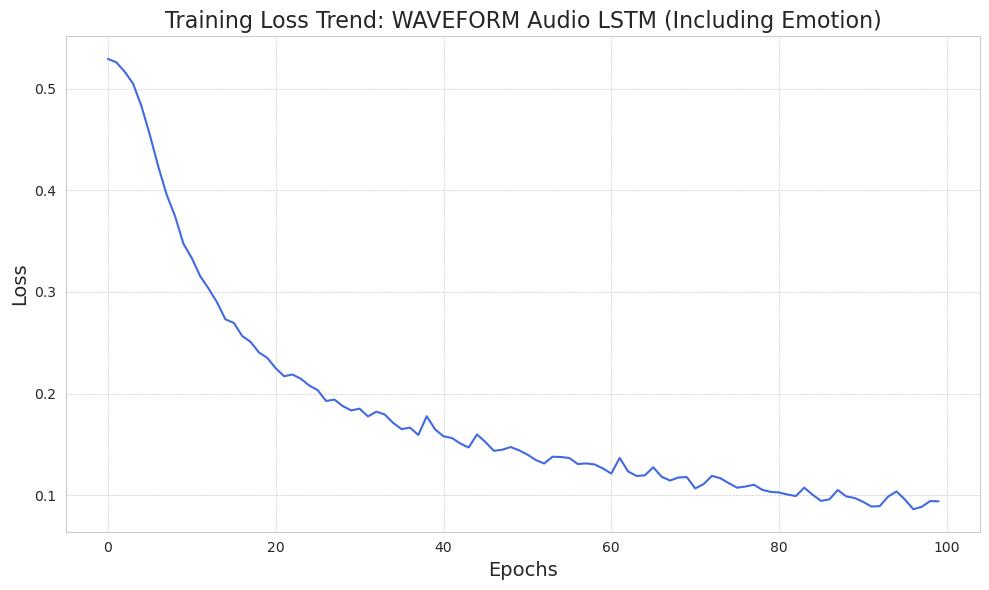

In [14]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,6))  # 크기를 조절하여 더 깔끔하게 보이게 합니다.
plt.plot(train_loss_history, color='royalblue')  # royalblue는 전문적이면서도 보기 좋은 파란색입니다.
plt.title("Training Loss Trend: WAVEFORM Audio LSTM (Including Emotion)", fontsize=16)  
plt.xlabel("Epochs", fontsize=14)  # x축 라벨 추가
plt.ylabel("Loss", fontsize=14)  # y축 라벨 추가
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # 그리드 추가
plt.tight_layout()  # 레이아웃 최적화"
plt.show()


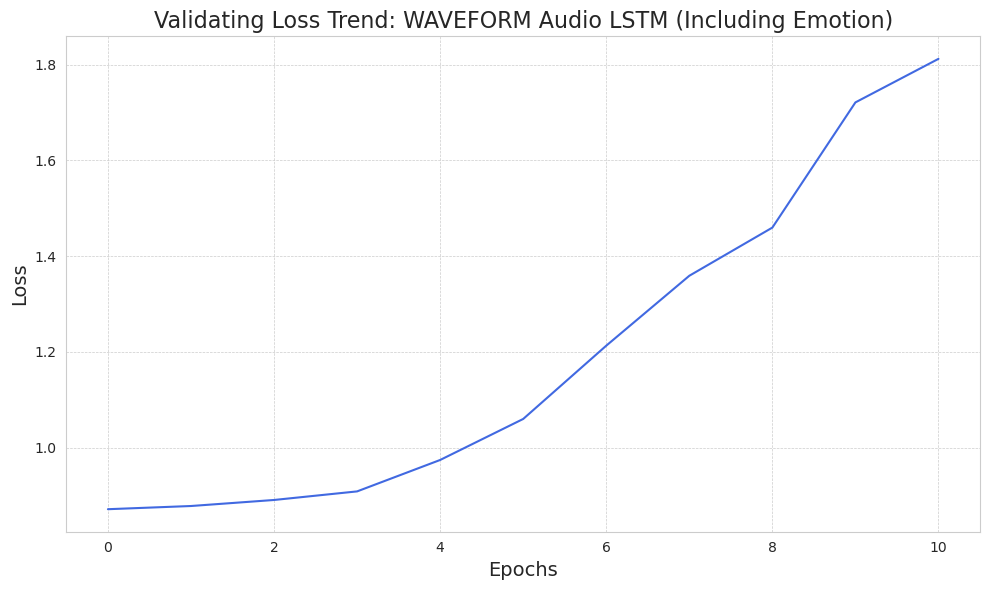

In [15]:

plt.figure(figsize=(10,6))  # 크기를 조절하여 더 깔끔하게 보이게 합니다.
plt.plot(val_loss_history, color='royalblue')  # royalblue는 전문적이면서도 보기 좋은 파란색입니다.
plt.title("Validating Loss Trend: WAVEFORM Audio LSTM (Including Emotion)", fontsize=16)  
plt.xlabel("Epochs", fontsize=14)  # x축 라벨 추가
plt.ylabel("Loss", fontsize=14)  # y축 라벨 추가
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # 그리드 추가
plt.tight_layout()  # 레이아웃 최적화
plt.show()


# Save Model

In [18]:
import torch
from datetime import datetime
import os

current_time = datetime.now().strftime("%Y%m%d_%H%M")
save_dir = "Model/Audio"
os.makedirs(save_dir, exist_ok=True)  # 디렉토리가 없으면 생성

model_path = os.path.join(save_dir, f"audio_highlight_detection_wo_emotion_{current_time}.pt")
torch.save(model.state_dict(), model_path)



In [19]:
print(model_path)

Model/Audio/audio_highlight_detection_wo_emotion_20250419_2150.pt
